In [1]:
import os
import sys

from tqdm import tqdm
import numpy as np
import scipy as sp
import pandas as pd
import torch
from torch import nn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import datetime, timedelta, time

In [2]:
path = "./data/df_hack_final.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
df.shape

(30336, 130)

In [5]:
list(df.columns)

['MEAS_DT',
 'Cu_oreth',
 'Ni_oreth',
 'Ore_mass',
 'Mass_1',
 'Mass_2',
 'Dens_4',
 'Mass_4',
 'Vol_4',
 'Cu_4F',
 'Ni_4F',
 'Ni_4.1C',
 'Ni_4.1C_max',
 'Ni_4.1C_min',
 'Ni_4.1T',
 'Ni_4.1T_max',
 'Ni_4.1T_min',
 'FM_4.1_A',
 'Ni_4.2C',
 'Ni_4.2C_max',
 'Ni_4.2C_min',
 'Ni_4.2T',
 'Ni_4.2T_max',
 'Ni_4.2T_min',
 'FM_4.2_A',
 'Dens_5',
 'Mass_5',
 'Vol_5',
 'Ni_5F',
 'Ni_5.1C',
 'Ni_5.1C_max',
 'Ni_5.1C_min',
 'Ni_5.1T',
 'Ni_5.1T_max',
 'Ni_5.1T_min',
 'FM_5.1_A',
 'Ni_5.2C',
 'Ni_5.2C_max',
 'Ni_5.2C_min',
 'Ni_5.2T',
 'Ni_5.2T_max',
 'Ni_5.2T_min',
 'FM_5.2_A',
 'Dens_6',
 'Mass_6',
 'Vol_6',
 'Ni_6F',
 'Ni_6.1C',
 'Ni_6.1C_max',
 'Ni_6.1C_min',
 'Ni_6.1T',
 'Ni_6.1T_max',
 'Ni_6.1T_min',
 'FM_6.1_A',
 'Ni_6.2C',
 'Ni_6.2C_max',
 'Ni_6.2C_min',
 'Ni_6.2T',
 'Ni_6.2T_max',
 'Ni_6.2T_min',
 'FM_6.2_A',
 'Cu_resth',
 'Ni_resth',
 'Cu_1.1C',
 'Ni_1.1C',
 'Cu_1.2C',
 'Ni_1.2C',
 'Cu_2F',
 'Ni_2F',
 'Cu_2.1C',
 'Ni_2.1C',
 'Cu_2.2C',
 'Ni_2.2C',
 'Cu_3F',
 'Ni_3F',
 'Cu_3.1C',
 'Ni_3.1C',

In [49]:
data = df[df['FM_4.1_A'] == 1]
target = (data['Ni_4.1C_max'] + data['Ni_4.1C_min']) / 2
diff  = data['Ni_4.1C'] - target

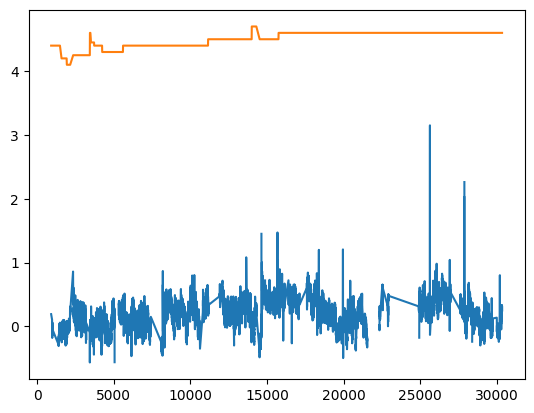

In [50]:
plt.plot(diff)
plt.plot(target)

Finding time floatation by blocks

In [19]:
def calc_corr(df, input_col='Ni_oreth', out_1_col='Ni_1.1C', out_2_col='Ni_1.2C'):
    corr_1, corr_2 = np.zeros((df.shape[0] // 2000, 4 * 8)), np.zeros((df.shape[0] // 2000, 32))
    for j in range(df.shape[0] // 2000):

        for i in range(0, 4 * 8):
            data = df[j * 2000:(j + 1) * 2000]
            data = data[[input_col, out_1_col, out_2_col]].dropna(axis=0)
            if i == 0:
                corr_1[j, i] = sp.stats.pearsonr(data[input_col], data[out_1_col])[0]
                corr_2[j, i] = sp.stats.pearsonr(data[input_col], data[out_2_col])[0]
            else:
                try:
                    corr_1[j, i] = sp.stats.pearsonr(data[input_col].iloc[:-i], data[out_1_col].iloc[i:])[0]
                except:
                    corr_1[j, i] = np.nan
                try:
                    corr_2[j, i] = sp.stats.pearsonr(data[input_col].iloc[:-i], data[out_2_col].iloc[i:])[0]
                except:
                    corr_2[j, i] = np.nan
    return corr_1, corr_2
    
def plot_corr(corr_1, corr_2, out_1_col, out_2_col):
    plt.plot(corr_1.mean(axis=0), label=f"{out_1_col}")
    plt.plot(corr_2.mean(axis=0), label=f"{out_2_col}")
    plt.ylabel("Correlation")
    plt.title(f"{out_1_col} mean time {np.argsort(corr_1.mean(axis=0))[-1] * 15} m\n{out_1_col} mean time {np.argsort(corr_2.mean(axis=0))[-1] * 15} m")
    ax = plt.gca()
    current_xticks = ax.get_xticks()
    new_xticks = [f"{int(tick * 15)}" for tick in current_xticks]
    ax.set_xticklabels(new_xticks)
    plt.legend()

C:\Users\Cape\AppData\Local\Temp\ipykernel_25696\1251935531.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticks)


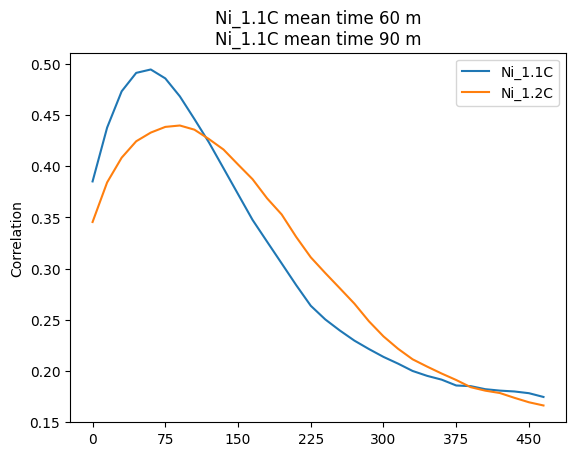

In [308]:
corr_1, corr_2 = calc_corr(df, input_col='Ni_oreth', out_1_col='Ni_1.1C', out_2_col='Ni_1.2C')
plot_corr(corr_1, corr_2, out_1_col='Ni_1.1C', out_2_col='Ni_1.2C')

C:\Users\Cape\AppData\Local\Temp\ipykernel_25696\1251935531.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticks)


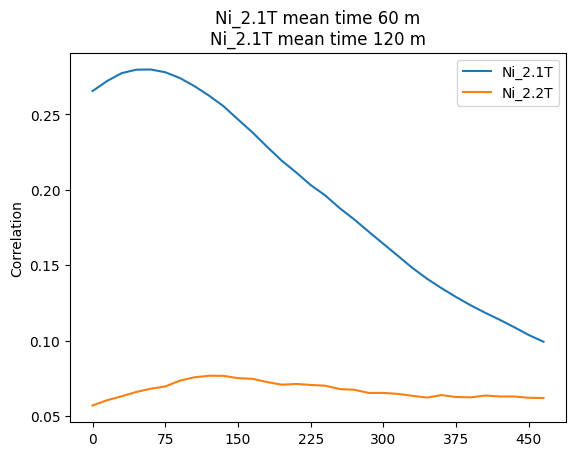

In [309]:
corr_1, corr_2 = calc_corr(df, input_col='Ni_2F', out_1_col='Ni_2.1T', out_2_col='Ni_2.2T')
plot_corr(corr_1, corr_2, out_1_col='Ni_2.1T', out_2_col='Ni_2.2T')

C:\Users\Cape\AppData\Local\Temp\ipykernel_25696\1251935531.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticks)


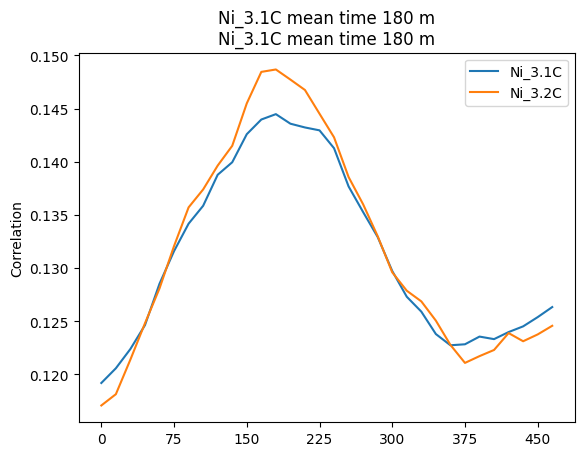

In [327]:
corr_1, corr_2 = calc_corr(df, input_col='Ni_oreth', out_1_col='Ni_3.1C', out_2_col='Ni_3.2C')
plot_corr(corr_1, corr_2, out_1_col='Ni_3.1C', out_2_col='Ni_3.2C')

C:\Users\Cape\AppData\Local\Temp\ipykernel_25696\1251935531.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticks)


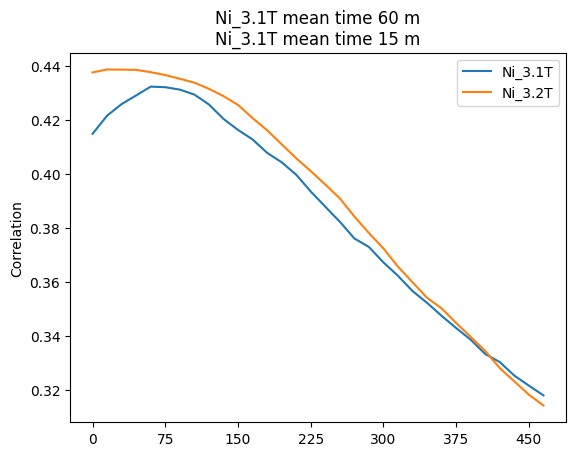

In [310]:
corr_1, corr_2 = calc_corr(df, input_col='Ni_3F', out_1_col='Ni_3.1T', out_2_col='Ni_3.2T')
plot_corr(corr_1, corr_2, out_1_col='Ni_3.1T', out_2_col='Ni_3.2T')

C:\Users\Cape\AppData\Local\Temp\ipykernel_25696\1251935531.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticks)


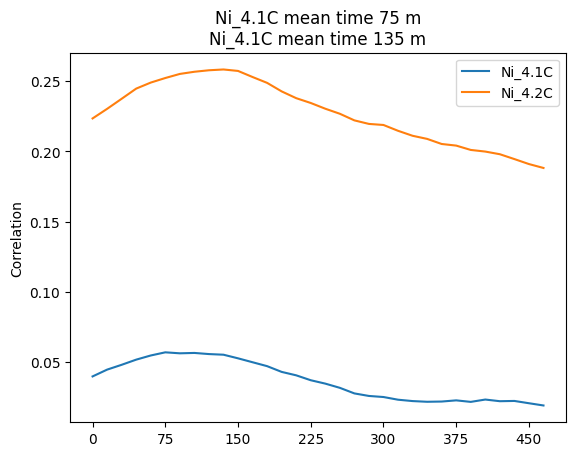

In [316]:
corr_1, corr_2 = calc_corr(df, input_col='Ni_2F', out_1_col='Ni_4.1C', out_2_col='Ni_4.2C')
plot_corr(corr_1, corr_2, out_1_col='Ni_4.1C', out_2_col='Ni_4.2C')

C:\Users\Cape\AppData\Local\Temp\ipykernel_25696\1251935531.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticks)


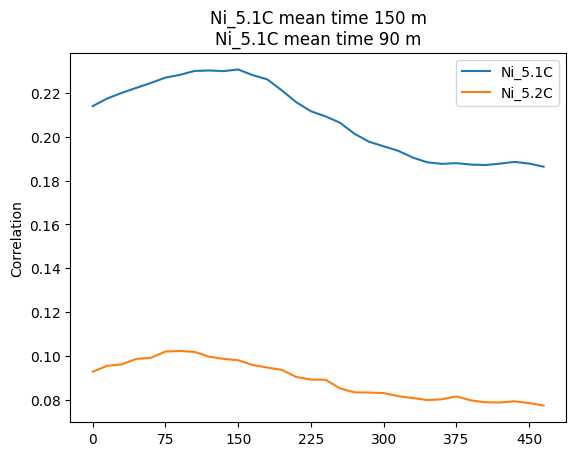

In [317]:
corr_1, corr_2 = calc_corr(df, input_col='Ni_2F', out_1_col='Ni_5.1C', out_2_col='Ni_5.2C')
plot_corr(corr_1, corr_2, out_1_col='Ni_5.1C', out_2_col='Ni_5.2C')

C:\Users\Cape\AppData\Local\Temp\ipykernel_27524\1251935531.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticks)


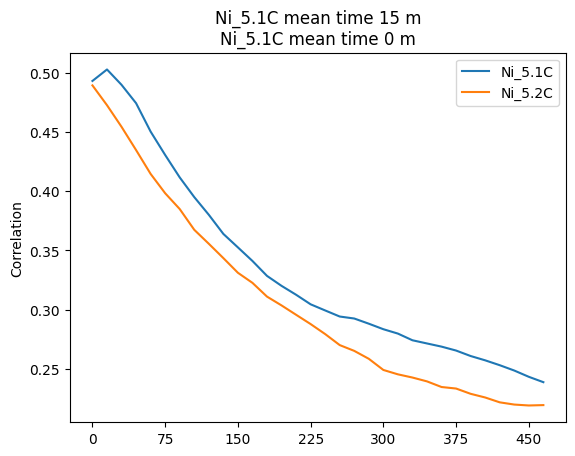

In [23]:
corr_1, corr_2 = calc_corr(df, input_col='Ni_5F', out_1_col='Ni_5.1C', out_2_col='Ni_5.2C')
plot_corr(corr_1, corr_2, out_1_col='Ni_5.1C', out_2_col='Ni_5.2C')

C:\Users\Cape\AppData\Local\Temp\ipykernel_27524\1251935531.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticks)


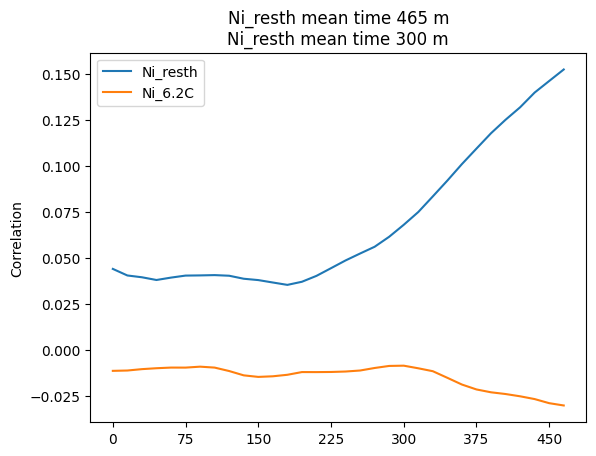

In [26]:
corr_1, corr_2 = calc_corr(df, input_col='Ni_oreth', out_1_col='Ni_resth', out_2_col='Ni_6.2C')
plot_corr(corr_1, corr_2, out_1_col='Ni_resth', out_2_col='Ni_6.2C')

In [ ]:
corr_1, corr_2 = calc_corr(df, input_col='Ni_6F', out_1_col='Ni_resth', out_2_col='Ni_6.2T')
plot_corr(corr_1, corr_2, out_1_col='Ni_resth', out_2_col='Ni_6.2T')

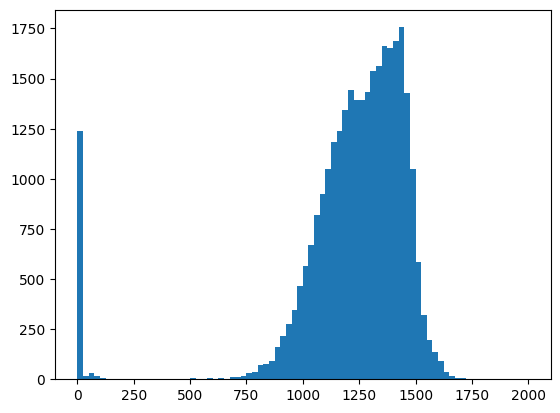

In [177]:
_ = plt.hist(df['Ore_mass'], bins=80)

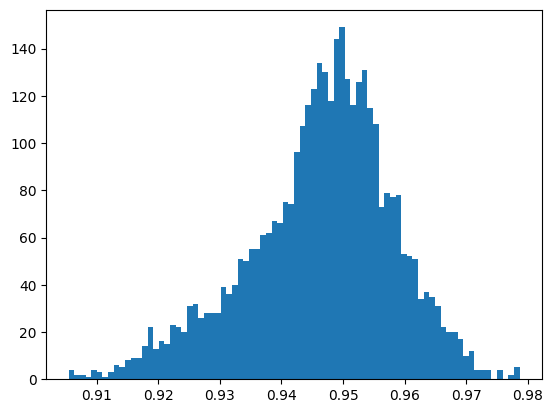

In [165]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4*8, step=4)
_ = plt.hist(df['Ni_rec'].rolling(window=indexer, min_periods=2).mean()[::8], bins=80)

In [ ]:
df['Ni_6.1C'] * 

In [159]:
df['Ni_rec'][2:34].mean()

0.9679259640053757

In [10]:
df.where(df[['Dens_1']] > 1.1, other=np.nan, inplace=True)
df.where(df[['Ni_rec']] != 1, other=np.nan, inplace=True)
# df.where(df[['Ni_rec']] != 1, other=np.nan, inplace=True)

In [137]:
data = df['Ni_rec'].dropna().to_numpy().reshape(-1, 1)
dbscan = DBSCAN(eps=0.0005, min_samples=500).fit(data)
first_cluster_indices = np.where(dbscan.labels_ == 0)[0]
first_cluster_data = data[first_cluster_indices]
second_cluster_indices = np.where(dbscan.labels_ == 1)[0]
second_cluster_data = data[second_cluster_indices]

mu_1 = np.mean(first_cluster_data)
sigma_1 = np.std(first_cluster_data)
mu_2 = np.mean(second_cluster_data)
sigma_2 = np.std(second_cluster_data)

x = np.linspace(.9, 1., 500)
y_1 = norm.pdf(x, loc=mu_1, scale=sigma_1)
y_2 = norm.pdf(x, loc=mu_2, scale=sigma_2)

In [138]:
mu_1, mu_2

(0.9701370104197317, 0.9396088915921691)

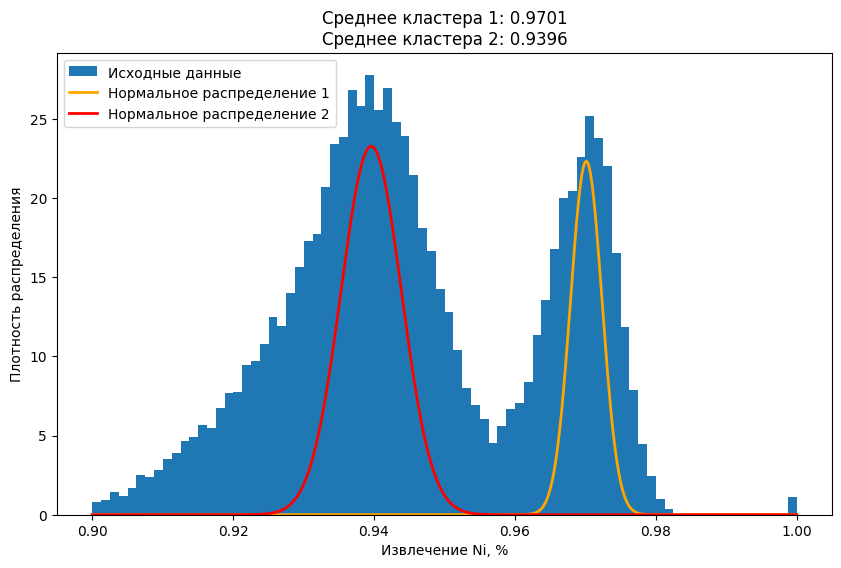

In [148]:
plt.figure(figsize=(10, 6))
plt.hist(data[data > .9], bins=80, density=True, label='Исходные данные')
plt.plot(x, y_1 / 8, color='orange', linewidth=2, label='Нормальное распределение 1')
plt.plot(x, y_2 / 4, color='red', linewidth=2, label='Нормальное распределение 2')
plt.title(f"Среднее кластера 1: {mu_1:.4f}\nCреднее кластера 2: {mu_2:.4f}")
plt.xlabel("Извлечение Ni, %")
plt.ylabel("Плотность распределения")
plt.legend()

In [11]:
data = df[['Ni_rec', 'FM_6.1_A', 'FM_6.2_A']]

(0.9, 1.0)

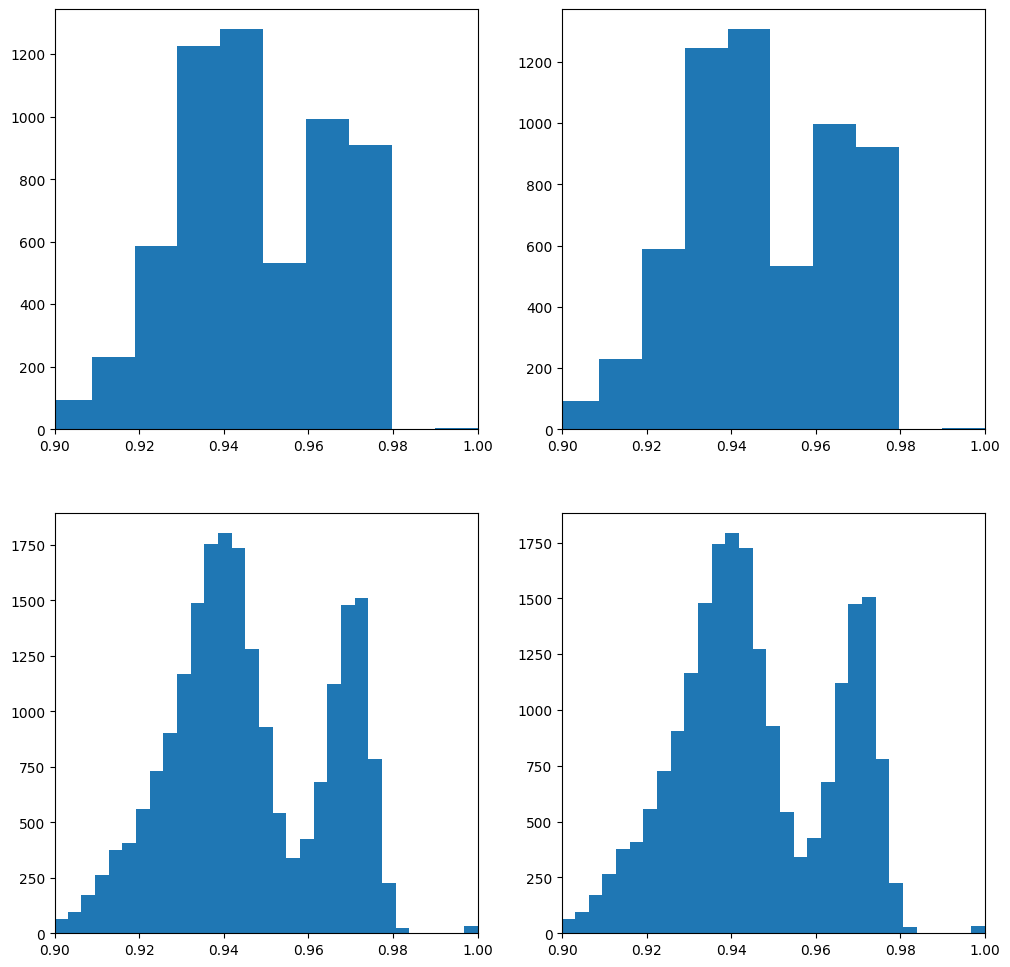

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax[0, 0].hist(data[data['FM_6.1_A'] == 1]['Ni_rec'], bins=40)
ax[0, 0].set_xlim((.9, 1.))
ax[1, 0].hist(data[data['FM_6.1_A'] == 0]['Ni_rec'], bins=40)
ax[1, 0].set_xlim((.9, 1.))
ax[0, 1].hist(data[data['FM_6.2_A'] == 1]['Ni_rec'], bins=40)
ax[0, 1].set_xlim((.9, 1.))
ax[1, 1].hist(data[data['FM_6.2_A'] == 0]['Ni_rec'], bins=40)
ax[1, 1].set_xlim((.9, 1.))

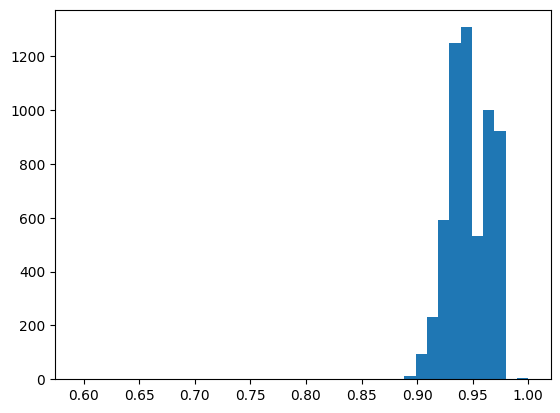

In [13]:
_ = plt.hist(data[data['FM_6.2_A'] == 1]['Ni_rec'], bins=40)

In [78]:
data[data['FM_6.1_A'] == 1]['Ni_rec']

920      0.963526
921      0.926289
922      0.926593
923      0.930079
924      0.967459
           ...   
29339    0.945063
29340    0.944434
29341    0.944046
29342    0.944161
29343    0.946873
Name: Ni_rec, Length: 6375, dtype: float64

In [67]:
data = df[['Ni_oreth', 'Cu_oreth', 'Dens_1']].dropna()
data = data.reset_index(drop=True)
dbscan = DBSCAN(eps=0.05, min_samples=100).fit(data.to_numpy())
print(np.unique(dbscan.labels_))
first_cluster_indices = np.where(dbscan.labels_ == 0)[0]
first_cluster_data = data.iloc[first_cluster_indices]
# second_cluster_indices = np.where(dbscan.labels_ == 1)[0]
# second_cluster_data = data[second_cluster_indices]



mu_1 = np.mean(first_cluster_data)
sigma_1 = np.std(first_cluster_data)
# mu_2 = np.mean(second_cluster_data)
# sigma_2 = np.std(second_cluster_data)

print(mu_1, sigma_1)
# print(mu_2, sigma_2)


[-1  0]
Ni_oreth    1.683514
Cu_oreth    2.698189
Dens_1      1.413122
dtype: float64 Ni_oreth    0.142135
Cu_oreth    0.233489
Dens_1      0.029163
dtype: float64


C:\Users\Cape\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Text(0, 0.5, 'Dens_1')

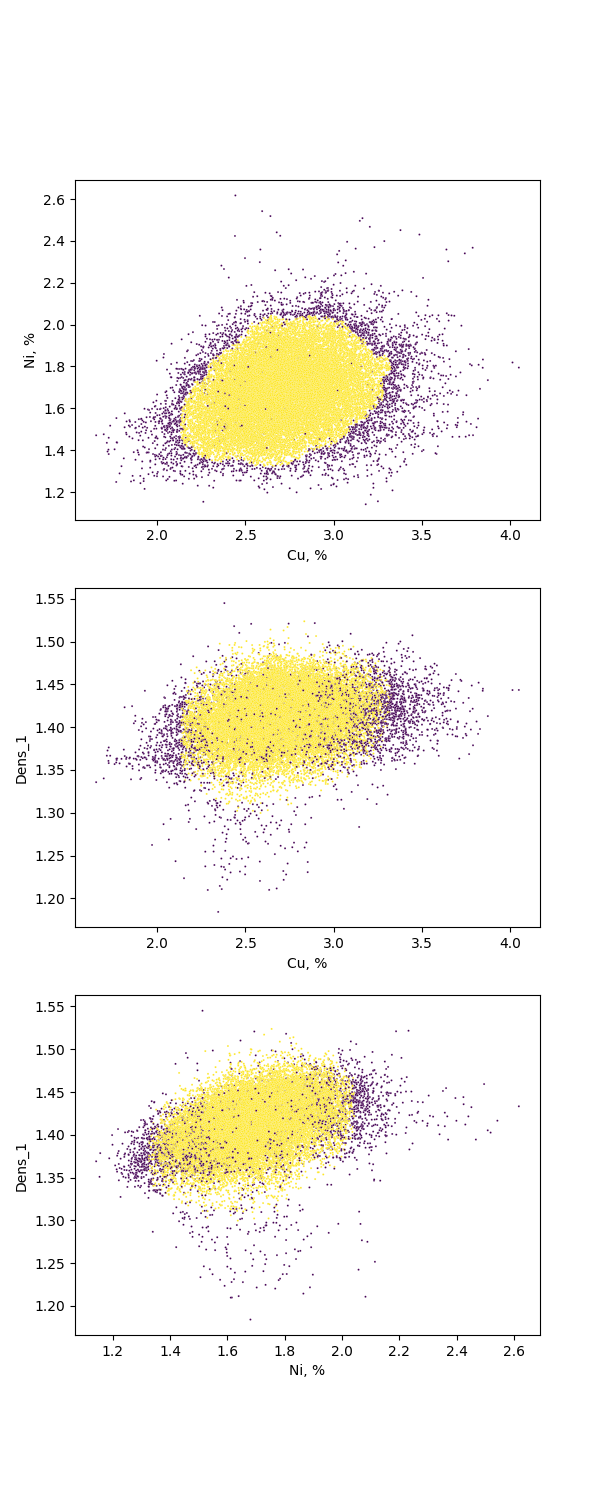

In [68]:
fig, ax = plt.subplots(nrows=3, figsize=(6, 15))

sns.scatterplot(data=data, x="Cu_oreth", y="Ni_oreth", ax=ax[0], s=2, c=dbscan.labels_)
ax[0].set_xlabel("Cu, %")
ax[0].set_ylabel("Ni, %")
sns.scatterplot(data=data, x="Cu_oreth", y="Dens_1", ax=ax[1], s=2, c=dbscan.labels_)
ax[1].set_xlabel("Cu, %")
ax[1].set_ylabel("Dens_1")
sns.scatterplot(data=data, x="Ni_oreth", y="Dens_1", ax=ax[2], s=2, c=dbscan.labels_)
ax[2].set_xlabel("Ni, %")
ax[2].set_ylabel("Dens_1")

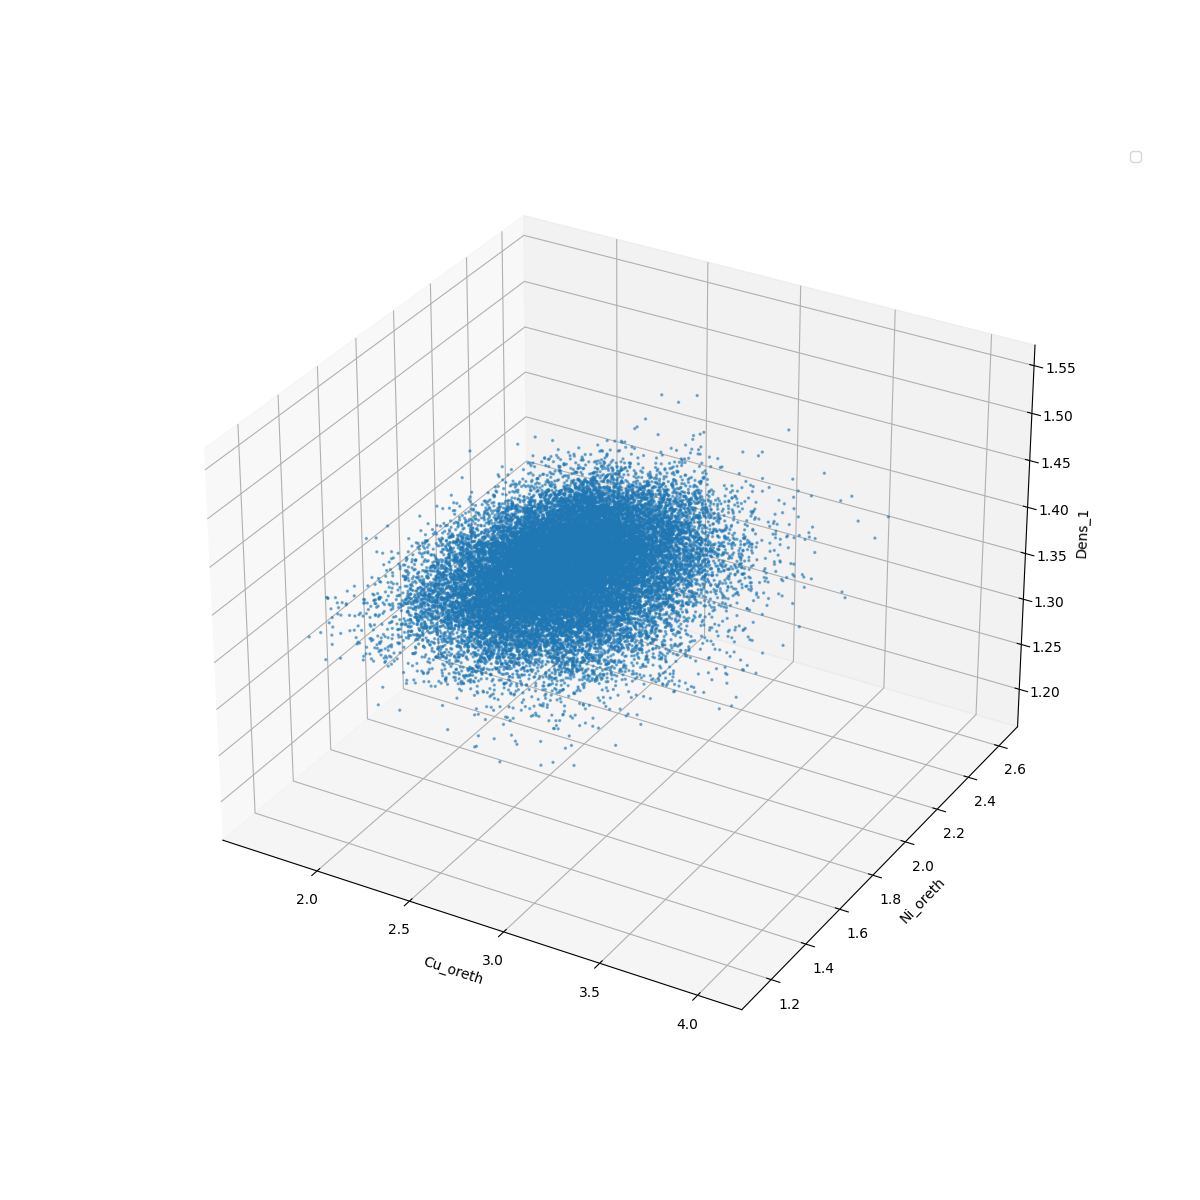

In [70]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

# plot
sc = ax.scatter(df['Cu_oreth'], df['Ni_oreth'], df['Dens_1'], s=2, marker='o', alpha=.5)
ax.set_xlabel('Cu_oreth')
ax.set_ylabel('Ni_oreth')
ax.set_zlabel('Dens_1')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

Text(0, 0.5, 'Dens_1')

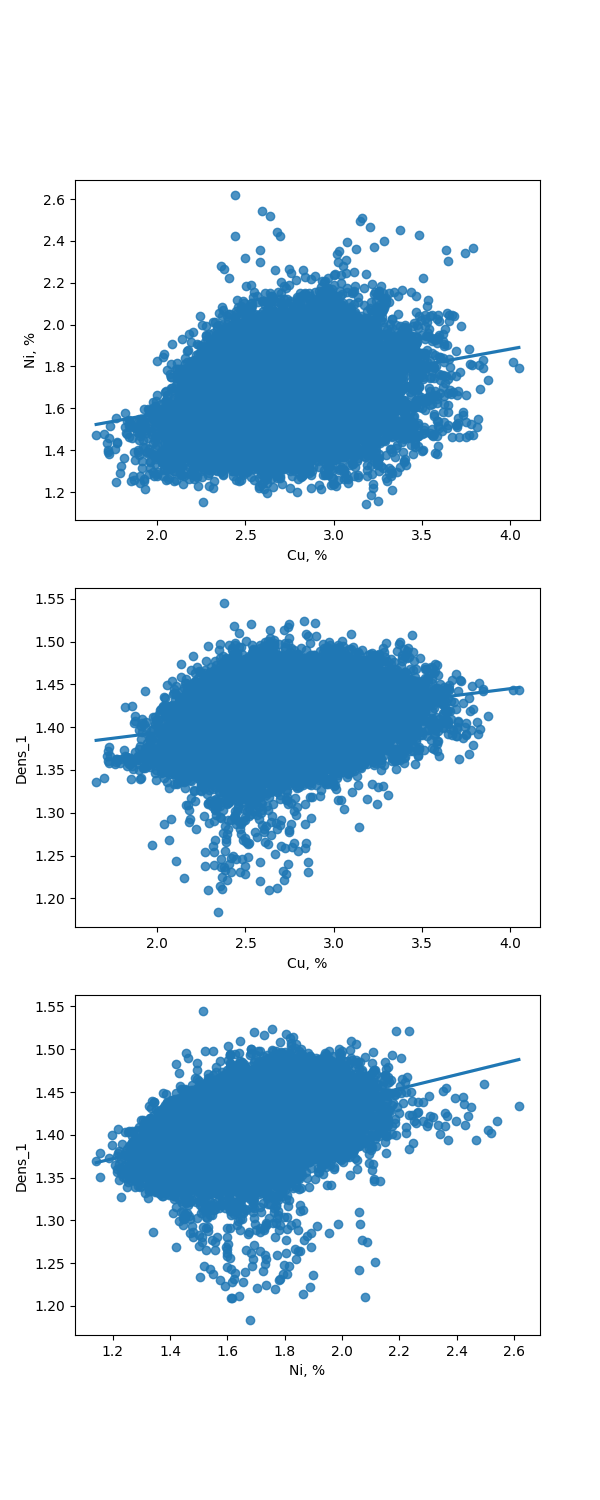

In [71]:
fig, ax = plt.subplots(nrows=3, figsize=(6, 15))

sns.regplot(data=df, x="Cu_oreth", y="Ni_oreth", ax=ax[0], order=1)
ax[0].set_xlabel("Cu, %")
ax[0].set_ylabel("Ni, %")
sns.regplot(data=df, x="Cu_oreth", y="Dens_1", ax=ax[1], order=1)
ax[1].set_xlabel("Cu, %")
ax[1].set_ylabel("Dens_1")
sns.regplot(data=df, x="Ni_oreth", y="Dens_1", ax=ax[2], order=1)
ax[2].set_xlabel("Ni, %")
ax[2].set_ylabel("Dens_1")

Text(0, 0.5, 'Ni recovery, %')

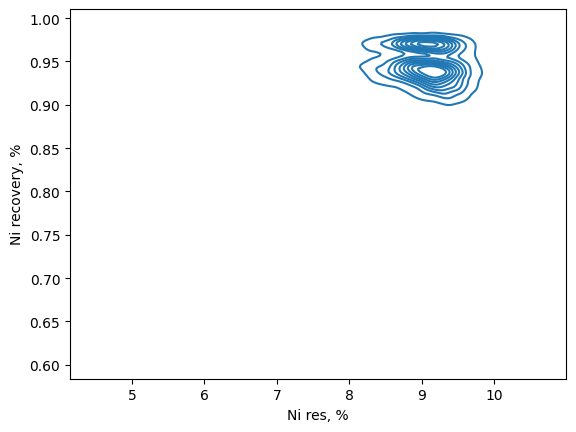

In [30]:
sns.kdeplot(data=df, x="Ni_resth", y="Ni_rec")
plt.xlabel("Ni res, %")
plt.ylabel("Ni recovery, %")

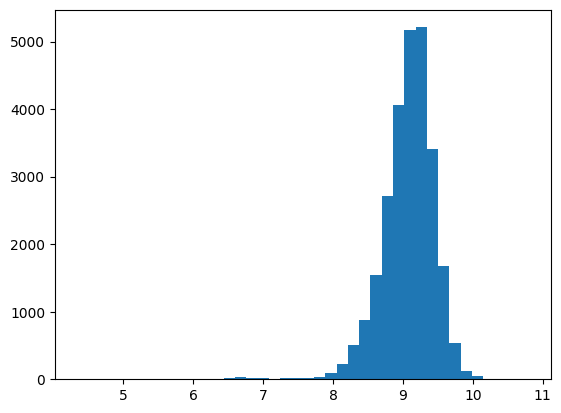

In [32]:
_ = plt.hist(df['Ni_resth'], bins=40)

In [ ]:
sns.kdeplot(data=df, x="Cu_resth", y="Ni_resth")
plt.xlabel("Cu, %")
plt.ylabel("Ni, %")

In [ ]:
sns.kdeplot(data=df, x="Cu_oreth", y="Ni_oreth")
plt.xlabel("Cu, %")
plt.ylabel("Ni, %")

Text(0, 0.5, 'Ni, %')

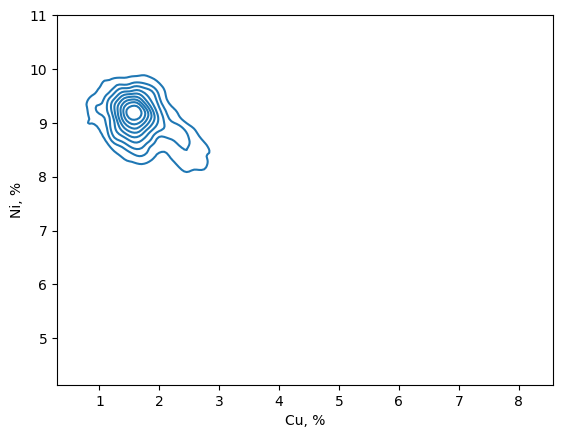

In [57]:
sns.kdeplot(data=df, x="Cu_resth", y="Ni_resth")
plt.xlabel("Cu, %")
plt.ylabel("Ni, %")

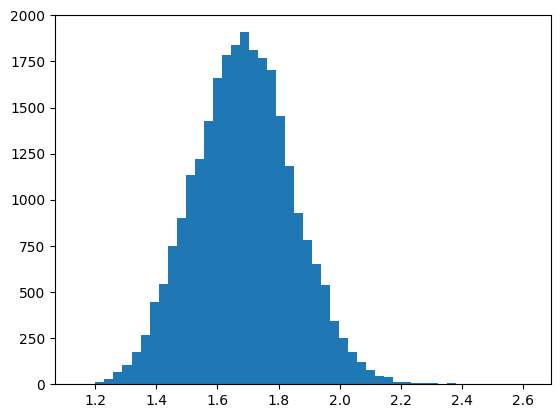

In [22]:
_ = plt.hist(df['Ni_oreth'], bins=50)

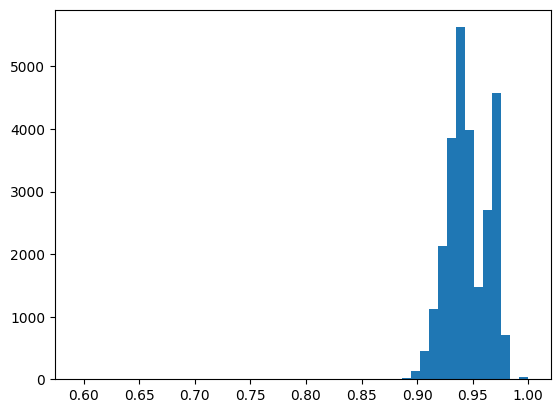

In [99]:
_ = plt.hist(df['Ni_rec'], bins=50)

Text(0, 0.5, 'Ore_mass')

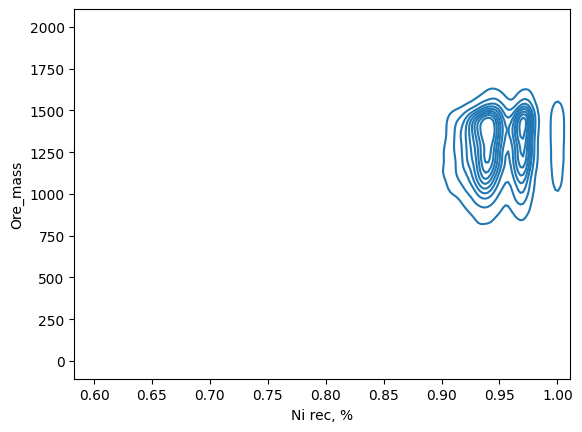

In [46]:
sns.kdeplot(data=df, x="Ni_rec", y="Ore_mass")
plt.xlabel("Ni rec, %")
plt.ylabel("Ore_mass")

Text(0, 0.5, 'Ni_oreth, %')

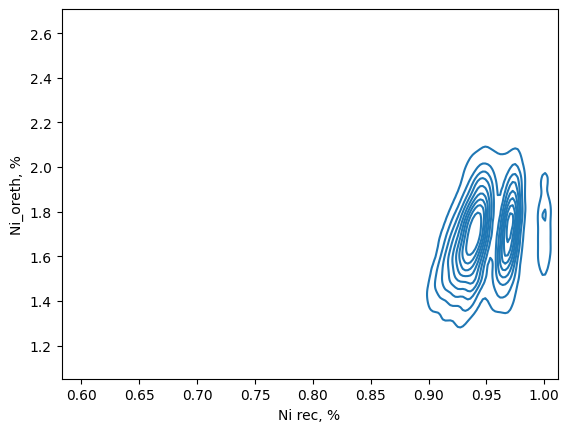

In [66]:
sns.kdeplot(data=df, x="Ni_rec", y="Ni_oreth")
plt.xlabel("Ni rec, %")
plt.ylabel("Ni_oreth, %")

Text(0, 0.5, 'Sum automatic')

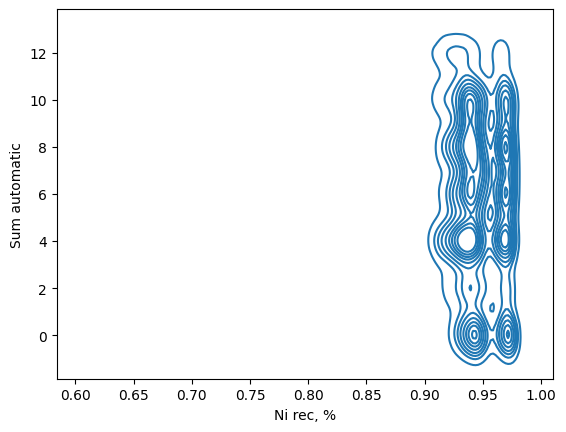

In [100]:
df['sum_automatic'] = df[['FM_1.1_A', 'FM_1.2_A',
                          'FM_2.1_A', 'FM_2.2_A',
                          'FM_3.1_A', 'FM_3.2_A',
                          'FM_4.1_A', 'FM_4.2_A',
                          'FM_5.1_A', 'FM_5.2_A',
                          'FM_6.1_A', 'FM_6.2_A',]].sum(axis=1)

sns.kdeplot(data=df, x="Ni_rec", y="sum_automatic")
plt.xlabel("Ni rec, %")
plt.ylabel("Sum automatic")

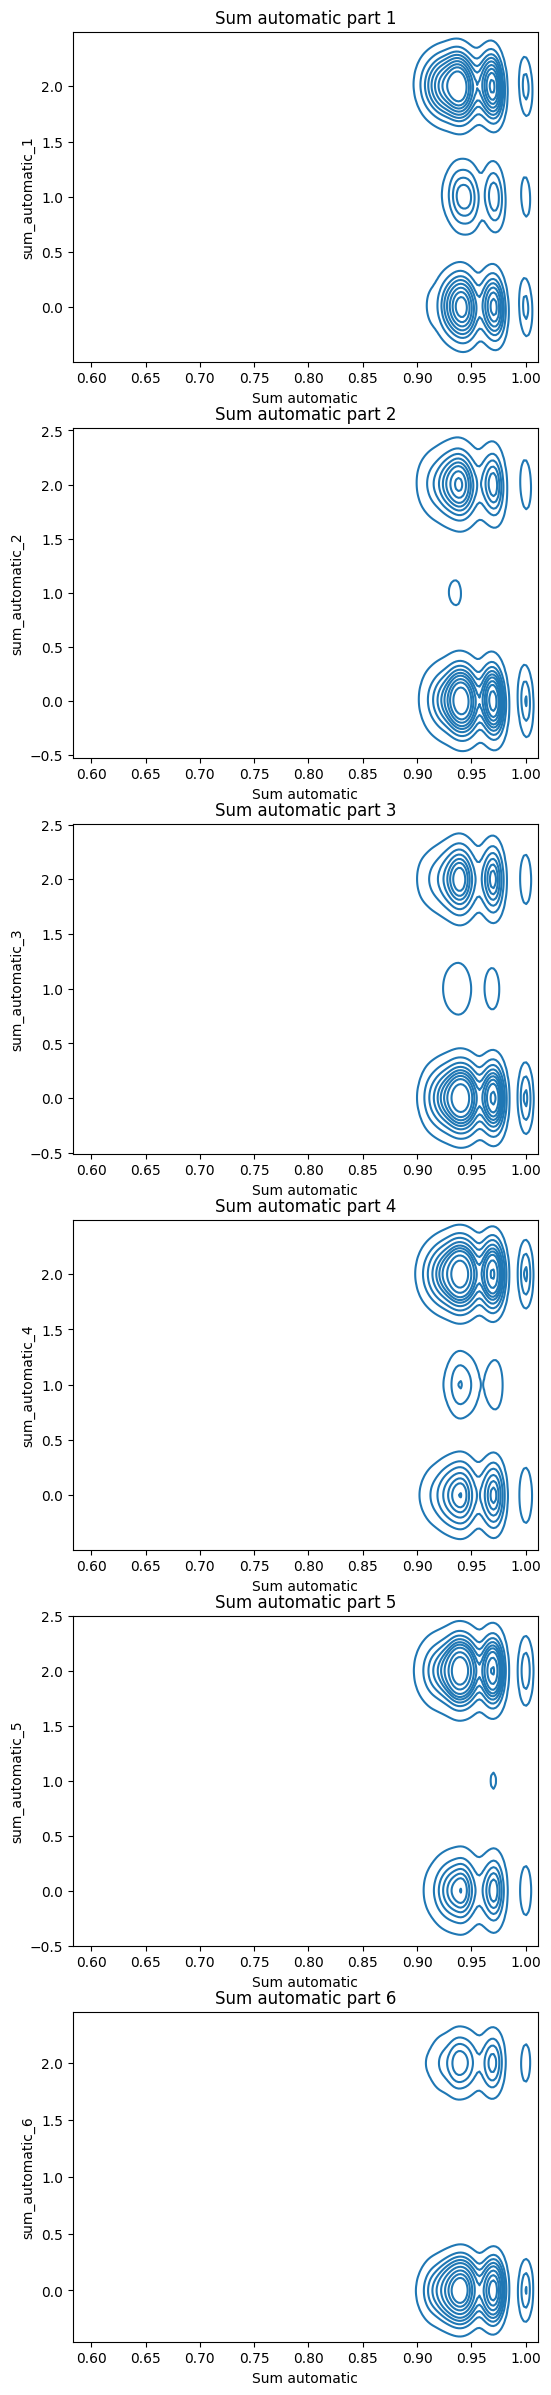

In [63]:
for i in range(1, 7):
    df[f'sum_automatic_{i}'] = df[[f'FM_{i}.1_A', f'FM_{i}.2_A']].sum(axis=1)

fig, ax = plt.subplots(nrows=6, figsize=(6, 30))
for i in range(1, 7):
    sns.kdeplot(data=df, x="Ni_rec", y=f"sum_automatic_{i}", ax=ax[i - 1])
    ax[i - 1].set_xlabel("Ni rec, %")
    ax[i - 1].set_xlabel("Sum automatic")
    ax[i - 1].set_title(f"Sum automatic part {i}")

Text(0, 0.5, 'Sum automatic')

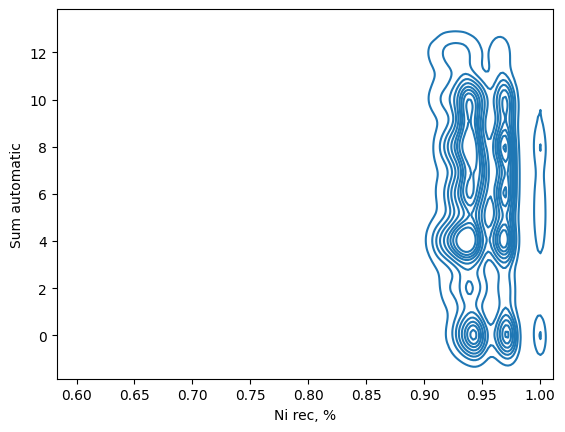

In [60]:
df['sum_automatic'] = df[[f"sum_automatic_{i}" for i in range(1, 7)]].sum(axis=1)
sns.kdeplot(data=df, x="Ni_rec", y="sum_automatic")
plt.xlabel("Ni rec, %")
plt.ylabel("Sum automatic")

In [ ]:
sns.kdeplot(data=df, x="Ni_rec", y="Ni_oreth")
plt.xlabel("Cu, %")
plt.ylabel("Ni, %")

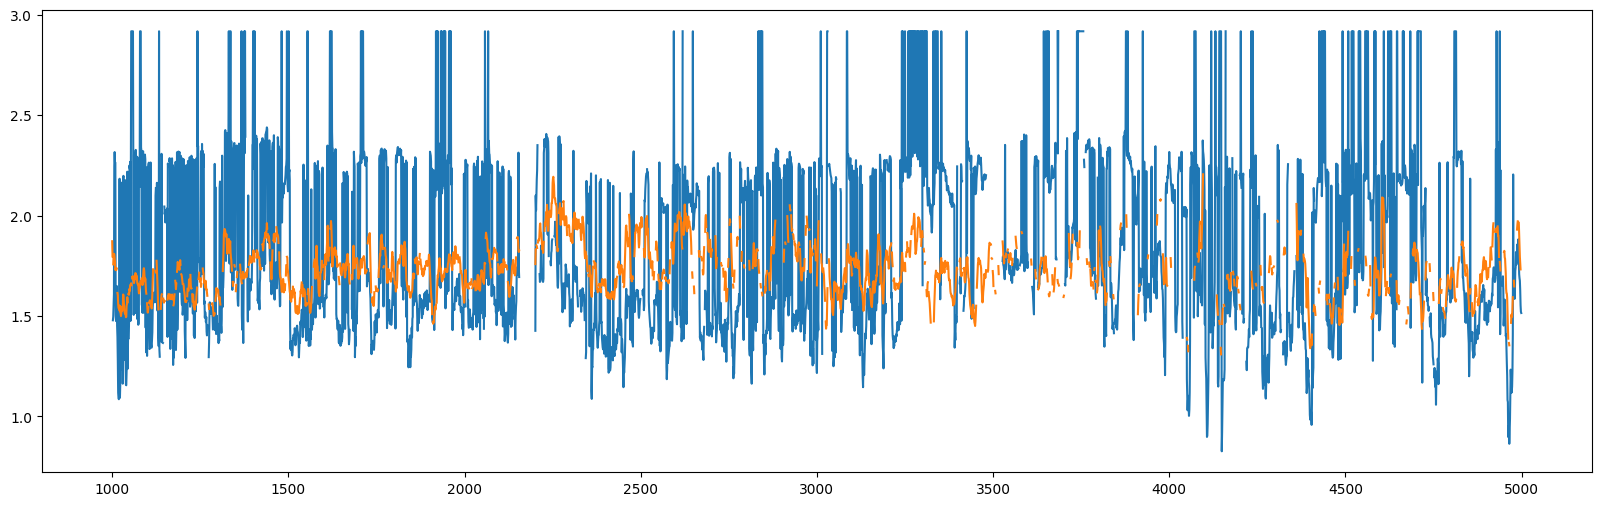

In [65]:
data = df[['Ni_oreth', 'Ni_rec']].dropna()
linreg = LinearRegression().fit(data[['Ni_oreth']], data['Ni_rec'])


plt.figure(figsize=(20, 6))
plt.plot((df['Ni_rec'][1000:5000] - linreg.intercept_) / linreg.coef_ )
plt.plot(df['Ni_oreth'][1000:5000])



In [45]:
linreg.coef_, linreg.intercept_

(array([0.04250568]), 0.8759730607533438)